In [25]:
import sqlite3
import numpy as np

In [26]:
def fetchTrainingData(db, sqlCmd):
    try:
        conn = sqlite3.connect(db)
        cursor = conn.cursor()
        cursor.execute(sqlCmd)
        result = cursor.fetchall()
        conn.commit()
        cursor.close()
        return result

    except sqlite3.Error as error:
        print("Failed to run sqlite command", error)
    finally:
        if (conn):
            conn.close()

In [27]:
db_path = 'db/categorised_swecris.sqlite'

In [28]:
init = False
for ix in range(2,18):
    sqlCmd = f'''
        SELECT abstract, Formas1 AS class FROM clean_swecris
            WHERE class == '{ix}' ORDER BY RANDOM() LIMIT 99
        '''
    result = np.array(fetchTrainingData(db_path, sqlCmd))
    if (not init and result.size > 0):
        training_data_Formas = np.copy(result)
        init = True
    elif (result.size > 0):
        training_data_Formas = np.vstack((training_data_Formas, result))

In [35]:
init = False
for ix in range(2,18):
    sqlCmd = f'''
        SELECT abstract, Self1 AS class FROM clean_swecris 
            WHERE Self1 == '{ix}' ORDER BY RANDOM()
            LIMIT
                CASE 
                    WHEN (99 - (SELECT count(Formas1) FROM clean_swecris WHERE Formas1 == '{ix}')) > 0
                        THEN (SELECT 99 - count(Formas1) FROM clean_swecris WHERE Formas1 == '{ix}')
                    ELSE 0
                END;
        '''
    result = np.array(fetchTrainingData(db_path, sqlCmd))
    if (not init and result.size > 0):
        training_data_Vinnova = np.copy(result)
        init = True
    elif (result.size > 0):
        training_data_Vinnova = np.vstack((training_data_Vinnova, result))

In [36]:
init = False
for ix in range(2,17):
    sqlCmd = f'''
        SELECT abstract, goals AS class FROM clean_goals
            WHERE class == '{ix}';
        '''
    result = np.array(fetchTrainingData(db_path, sqlCmd))
    if (not init and result.size > 0):
        training_data_Goals = np.copy(result)
        init = True
    else:
        training_data_Goals = np.vstack((training_data_Goals, result))

In [37]:
training_data = np.vstack((training_data_Goals, training_data_Formas, training_data_Vinnova))

In [38]:
import pandas as pd

In [39]:
training_data_df = pd.DataFrame(data=training_data[:,:], columns=['abstract', 'class'])

In [40]:
training_data_df.head()

,abstract,class
0,ingen hung hung vara en främst dödsorsak i vär...,2
1,god hälsa och välbefinnande god hälsa vara en ...,3
2,god utbildning för alla utbildning vara en gru...,4
3,jämställdhet jämställdhet mellan kvinna och ma...,5
4,ren vatten och sanitet för alla vatten vara en...,6


In [45]:
training_data_df['len'] = training_data_df['abstract'].apply(lambda s : len(s))

<AxesSubplot:ylabel='Frequency'>

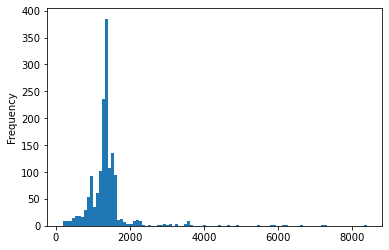

In [46]:
training_data_df['len'].plot.hist(bins=100)

In [47]:
training_data_df.len.quantile(0.9)

1604.8

In [23]:
from sqlalchemy import create_engine
table_name = 'Training_set'
db_path = 'db/training.sqlite'
db_path = 'sqlite:///' + db_path
engine = create_engine(db_path, echo=True)

In [24]:
training_data_df.to_sql(table_name, engine, if_exists='fail')

2020-12-16 02:08:31,445 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-12-16 02:08:31,446 INFO sqlalchemy.engine.base.Engine ()
2020-12-16 02:08:31,448 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-12-16 02:08:31,448 INFO sqlalchemy.engine.base.Engine ()
2020-12-16 02:08:31,450 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Training_set")
2020-12-16 02:08:31,450 INFO sqlalchemy.engine.base.Engine ()
2020-12-16 02:08:31,452 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Training_set")
2020-12-16 02:08:31,453 INFO sqlalchemy.engine.base.Engine ()
2020-12-16 02:08:31,455 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE "Training_set" (
	"index" BIGINT, 
	abstract TEXT, 
	class TEXT
)


2020-12-16 02:08:31,456 INFO sqlalchemy.engine.base.Engine ()
2020-12-16 02:08:31,470 INFO sqlalchemy.engine.base.Engine COMMIT
2020-12-16 02:08:31,471 INFO sqlalchemy.engine.ba